## Unsupervised learning: K-means cluster 
- We apply K-means clustering to identify any distinct clusters that may correlate to fraudulent job listings within the previously cleaned textual data

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

with open("../variable_storage/bow_matrices.pkl", "rb") as f:
    bow_matrices = pickle.load(f)

with open("../variable_storage/df_cleaned.pkl", "rb") as f:
    df_cleaned = pickle.load(f)

with open("../variable_storage/vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)


K-means clustering for column: description
                                         description  description_cluster
0  Food52, a fast-growing, James Beard Award-winn...                    1
1  Organised - Focused - Vibrant - Awesome!Do you...                    1
2  Our client, located in Houston, is actively se...                    1
3  THE COMPANY: ESRI – Environmental Systems Rese...                    1
4  JOB TITLE: Itemization Review ManagerLOCATION:...                    1


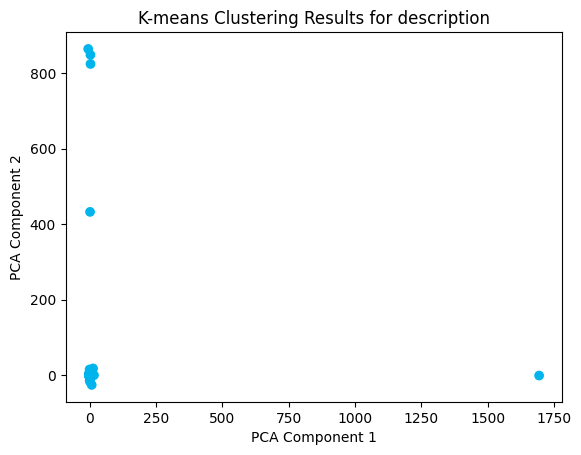


K-means clustering for column: requirements
                                        requirements  requirements_cluster
0  Experience with content management systems a m...                     0
1  What we expect from you:Your key responsibilit...                     0
2  Implement pre-commissioning and commissioning ...                     0
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...                     0
4  QUALIFICATIONS:RN license in the State of Texa...                     0


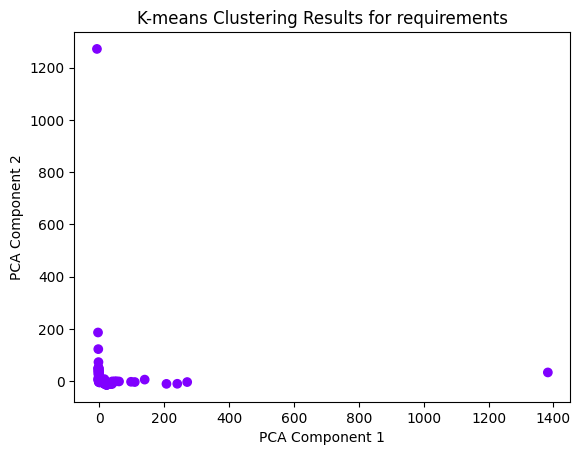


K-means clustering for column: benefits
                                            benefits  benefits_cluster
0                                       Not Provided                 3
1  What you will get from usThrough being part of...                 3
2                                       Not Provided                 3
3  Our culture is anything but corporate—we have ...                 3
4                              Full Benefits Offered                 3


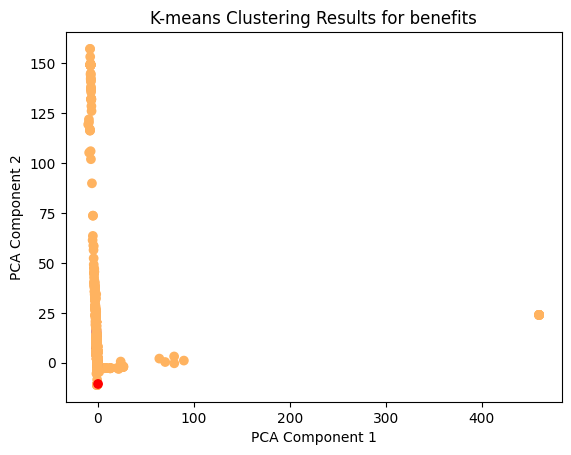


K-means clustering for column: title
                                       title  title_cluster
0                           Marketing Intern              1
1  Customer Service - Cloud Video Production              1
2    Commissioning Machinery Assistant (CMA)              1
3          Account Executive - Washington DC              1
4                        Bill Review Manager              1


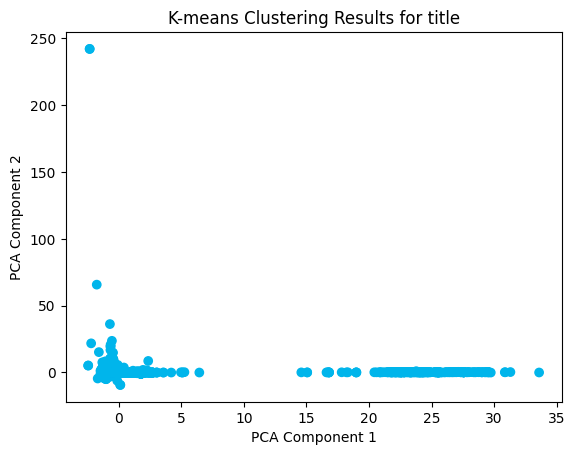


K-means clustering for column: company_profile
                                     company_profile  company_profile_cluster
0  We're Food52, and we've created a groundbreaki...                        0
1  90 Seconds, the worlds Cloud Video Production ...                        0
2  Valor Services provides Workforce Solutions th...                        0
3  Our passion for improving quality of life thro...                        0
4  SpotSource Solutions LLC is a Global Human Cap...                        0


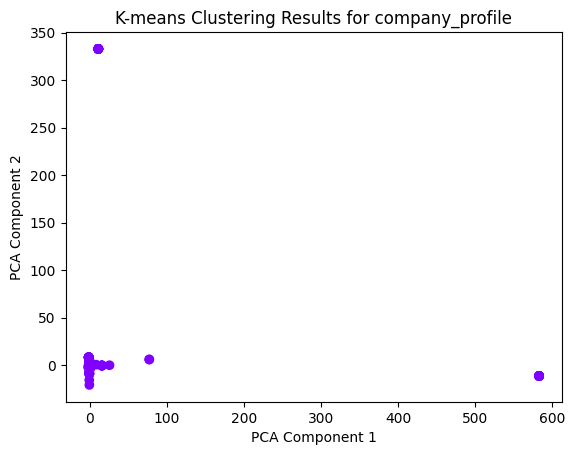

In [2]:
columns = ['description', 'requirements', 'benefits', 'title', 'company_profile']


# Dictionary to store K-means models and labels for each column
kmeans_models = {}
cluster_labels = {}

# Perform K-means clustering for each BoW matrix separately
for col in columns:
    print(f"\nK-means clustering for column: {col}")
    
    # Standardize the feature matrix
    scaler = StandardScaler(with_mean=False)
    scaled_features = scaler.fit_transform(bow_matrices[col])

    # Define the K-means model
    kmeans = KMeans(n_clusters=5, random_state=42)
    
    # Fit the model to the scaled features
    kmeans.fit(scaled_features)
    
    # Store the model and cluster labels
    kmeans_models[col] = kmeans
    cluster_labels[col] = kmeans.labels_
    
    # Add the cluster labels to your DataFrame
    df_cleaned[f'{col}_cluster'] = kmeans.labels_

    # Print sample cluster assignments
    print(df_cleaned[[col, f'{col}_cluster']].head())
    
    # Visualize clustering results with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features.toarray())  # Convert to dense for PCA

    plt.figure()
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='rainbow')
    plt.title(f'K-means Clustering Results for {col}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()


In [3]:
# Get the top words in each cluster
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(5):  # Assuming 5 clusters
    print(f"Cluster {i} top words:")
    top_words = [terms[ind] for ind in order_centroids[i, :10]]  # Top 10 words
    print(top_words)


Cluster 0 top words:
['and', 'to', 'the', 'in', 'is', 'of', 'for', 'we', 'our', 'with']
Cluster 1 top words:
['companywide', 'lei', 'craftsman', 'columbus', 'phases', 'craftsmanship', 'likewise', 'indianapolis', 'enhancements', 'tri']
Cluster 2 top words:
['pingdom', 'årets', 'servrar', 'industri', 'tillgänglighet', 'ägare', 'är', 'pingdoms', 'även', 'länder']
Cluster 3 top words:
['url_79acfcc7a99f008faaebd34c27f49d6df500e067c8eddd709a488e4201a00774', 'ανήκει', 'λειτουργικότητες', 'εταιρείας', 'ελληνικό', 'κύπρο', 'κάτι', 'ευρώπη', 'συμμετέχει', 'παρέχει']
Cluster 4 top words:
['marks', 'aspex', 'clientswe', 'marketplacecandidatesinclude', 'relating', 'specifications', 'recruitmentwe', 'standby', 'hunting', 'resourcing']


## Store Clusters in an excel sheet for visualisation purpose

In [4]:
import pandas as pd

# Initialize a writer for a multi-sheet Excel file
with pd.ExcelWriter("C:/Users/Aftershock/Desktop/BT4012/Group Project/BT4012fake_job_posting/dataset/clusters_per_column.xlsx") as writer:
    # Loop through each column to save clustering info
    for col in columns:
        # Create a DataFrame with the text data and corresponding cluster label for the column
        cluster_df = df_cleaned[[col, f'{col}_cluster']]
        
        # Rename columns for clarity in the Excel file
        cluster_df.columns = [f'{col}_text', 'cluster']
        
        # Sort by cluster to group all entries by cluster number
        cluster_df = cluster_df.sort_values(by='cluster')
        
        # Write the DataFrame to a new sheet named after the column
        cluster_df.to_excel(writer, sheet_name=f'{col}_clusters', index=False)

print("Clusters saved to clusters_per_column.xlsx")


Clusters saved to clusters_per_column.xlsx


## Analyse clusters against fraudulent job postings

In [5]:
# Dictionary to store accuracy and fraud distribution information for each column
cluster_analysis = {}

# Loop through each column to analyze clusters
for col in columns:
    # Group by cluster and calculate the number of fraudulent and non-fraudulent listings in each cluster
    cluster_fraud_counts = df_cleaned.groupby([f'{col}_cluster', 'fraudulent']).size().unstack(fill_value=0)
    
    # Calculate the total number of listings per cluster
    cluster_fraud_counts['total'] = cluster_fraud_counts.sum(axis=1)
    
    # Calculate the percentage of fraudulent listings in each cluster
    cluster_fraud_counts['fraud_percentage'] = (cluster_fraud_counts[1] / cluster_fraud_counts['total']) * 100
    
    # Determine the cluster accuracy by selecting clusters with high fraud concentration as fraudulent
    threshold = 50  # Define threshold for fraud concentration, e.g., >50% fraudulent listings in cluster
    cluster_fraud_counts['predicted_fraudulent'] = cluster_fraud_counts['fraud_percentage'] > threshold
    
    # Calculate accuracy: Compare predicted fraud clusters with actual fraud labels
    correct_predictions = (cluster_fraud_counts['predicted_fraudulent'] == (cluster_fraud_counts[1] > 0)).sum()
    total_clusters = cluster_fraud_counts.shape[0]
    accuracy = correct_predictions / total_clusters
    
    # Store the results
    cluster_analysis[col] = {
        'fraud_distribution': cluster_fraud_counts,
        'accuracy': accuracy
    }
    
    # Display the fraud distribution and accuracy for the column
    print(f"\nFraud analysis for column: {col}")
    print(cluster_fraud_counts[['total', 'fraud_percentage', 'predicted_fraudulent']])
    print(f"Accuracy for {col}: {accuracy:.2f}")





Fraud analysis for column: description
fraudulent           total  fraud_percentage  predicted_fraudulent
description_cluster                                               
0                       21        100.000000                  True
1                    17854          4.732833                 False
2                        1          0.000000                 False
3                        3          0.000000                 False
4                        1          0.000000                 False
Accuracy for description: 0.80

Fraud analysis for column: requirements
fraudulent            total  fraud_percentage  predicted_fraudulent
requirements_cluster                                               
0                     17874          4.845026                 False
1                         1          0.000000                 False
2                         3          0.000000                 False
3                         1          0.000000                 False
4          

From the data we can see that the first cluster, cluster 0 has a 100% fraudulent rate which indicates that the cluster may provide significant insight into identifying fraudulent job postings
